# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Описание данных

Данные находятся в файле /datasets/autos.csv. 

**Признаки** 

DateCrawled — дата скачивания анкеты из базы

VehicleType — тип автомобильного кузова

RegistrationYear — год регистрации автомобиля

Gearbox — тип коробки передач

Power — мощность (л. с.)

Model — модель автомобиля

Kilometer — пробег (км)

RegistrationMonth — месяц регистрации автомобиля

FuelType — тип топлива

Brand — марка автомобиля

Repaired — была машина в ремонте или нет

DateCreated — дата создания анкеты

NumberOfPictures — количество фотографий автомобиля

PostalCode — почтовый индекс владельца анкеты (пользователя)

LastSeen — дата последней активности пользователя

**Целевой признак**

Price — цена (евро)

# Оглавление 

1. Загрузка и изучение данных:

- Импортируем необходимые библиотеки, например, pandas и numpy.
- Загружаем данные из файла autos.csv.
- Ознакамливаемся с содержимым данных и их структурой.
- Обрабатываем пропущенные значения и аномалии в столбцах, а также удаляем 

2. Подготовка данных:

- Разделяем данные на признаки (X) и целевую переменную (y), где X содержит все столбцы, кроме "Price", а y содержит столбец "Price".
- Преобразуем категориальные признаки в числовые с помощью метода кодирования, например, one-hot encoding или label encoding.
- Разделяем данные на обучающую и тестовую выборки.

3. Обучение разных моделей:

- Используем различные модели машинного обучения для обучения, включая модель градиентного бустинга (например, LightGBM) и другие модели, такие как линейная регрессия, случайный лес и т.д.
- Для каждой модели настраиваем разные гиперпараметры и оцениваем их производительность на обучающей выборке.
- Измеряем время обучения и время предсказания для каждой модели.

4. Анализ и выбор лучшей модели:

- Сравниваем производительность моделей по метрике RMSE на тестовой выборке.
- Оцениваем время обучения и время предсказания каждой модели.
- Исходя из критериев заказчика (качество предсказания, время обучения, время предсказания), выбираем лучшую модель.

5. Проверка качества выбранной модели:

- Проверяем качество выбранной модели на тестовой выборке.
- Измеряем значение метрики RMSE и сравниваем его с требуемым значением (меньше 2500).

6. Отчет:

- Подготавливаем отчет о проделанной работе, включая описание каждого шага и полученные результаты.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
pd.options.mode.chained_assignment = None
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('/datasets/autos.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
# Удаляем колонки, не влияющие на стоимость автомобиля
df = df.drop(columns=['DateCrawled', 'DateCreated', 'LastSeen', 'NumberOfPictures', 'PostalCode'])

# Проверяем результат удаления
print(df.head())

   Price VehicleType  RegistrationYear Gearbox  Power  Model  Kilometer  \
0    480         NaN              1993  manual      0   golf     150000   
1  18300       coupe              2011  manual    190    NaN     125000   
2   9800         suv              2004    auto    163  grand     125000   
3   1500       small              2001  manual     75   golf     150000   
4   3600       small              2008  manual     69  fabia      90000   

   RegistrationMonth  FuelType       Brand Repaired  
0                  0    petrol  volkswagen      NaN  
1                  5  gasoline        audi      yes  
2                  8  gasoline        jeep      NaN  
3                  6    petrol  volkswagen       no  
4                  7  gasoline       skoda       no  


In [5]:
# Находим колонки с пропущенными значениями и их количество
columns_with_missing_values = df.columns[df.isnull().any()]
missing_values_count = df[columns_with_missing_values].isnull().sum()

print("Колонки с пропущенными значениями:")
print(columns_with_missing_values)
print("\nКоличество пропущенных значений в каждой колонке:")
print(missing_values_count)

Колонки с пропущенными значениями:
Index(['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired'], dtype='object')

Количество пропущенных значений в каждой колонке:
VehicleType    37490
Gearbox        19833
Model          19705
FuelType       32895
Repaired       71154
dtype: int64


In [6]:
df[columns_with_missing_values] = df[columns_with_missing_values].fillna('unknown')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354369 non-null  int64 
 1   VehicleType        354369 non-null  object
 2   RegistrationYear   354369 non-null  int64 
 3   Gearbox            354369 non-null  object
 4   Power              354369 non-null  int64 
 5   Model              354369 non-null  object
 6   Kilometer          354369 non-null  int64 
 7   RegistrationMonth  354369 non-null  int64 
 8   FuelType           354369 non-null  object
 9   Brand              354369 non-null  object
 10  Repaired           354369 non-null  object
dtypes: int64(5), object(6)
memory usage: 29.7+ MB


In [7]:
# Проверка числовых признаков
numeric_columns = ['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']

# Отображение общей статистики числовых признаков
print(df[numeric_columns].describe())

               Price  RegistrationYear          Power      Kilometer  \
count  354369.000000     354369.000000  354369.000000  354369.000000   
mean     4416.656776       2004.234448     110.094337  128211.172535   
std      4514.158514         90.227958     189.850405   37905.341530   
min         0.000000       1000.000000       0.000000    5000.000000   
25%      1050.000000       1999.000000      69.000000  125000.000000   
50%      2700.000000       2003.000000     105.000000  150000.000000   
75%      6400.000000       2008.000000     143.000000  150000.000000   
max     20000.000000       9999.000000   20000.000000  150000.000000   

       RegistrationMonth  
count      354369.000000  
mean            5.714645  
std             3.726421  
min             0.000000  
25%             3.000000  
50%             6.000000  
75%             9.000000  
max            12.000000  


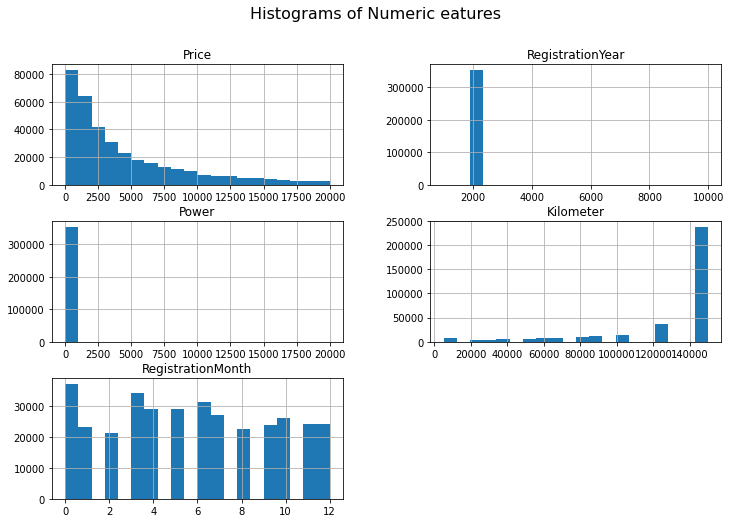

In [8]:
# Построение гистограмм для визуализации распределения данных
df[numeric_columns].hist(bins=20, figsize=(12, 8))
plt.suptitle("Histograms of Numeric eatures", fontsize=16)
plt.show()

- Price: средняя стоимость автомобиля составляет около 4416 евро, с минимальным значением 0 и максимальным 20000 евро. Стандартное отклонение велико, что может указывать на большой разброс цен.

- RegistrationYear: средний год регистрации автомобиля около 2004 года, с минимальным значением 1000 и максимальным 9999. Есть некоторые аномальные значения, например, года регистрации автомобилей до 1900 года.

- Power: средняя мощность автомобиля около 110 л.с., с минимальным значением 0 и максимальным 20000 л.с. Есть некоторые аномальные значения, например, мощность 0 л.с. и очень высокая мощность.

- Kilometer: средний пробег автомобиля около 128211 км, со значением 150000 км у большинства автомобилей.
RegistrationMonth: средний месяц регистрации автомобиля около 6 (июнь).

In [9]:
# Удаление строк с аномальными значениями в столбце Price (цена не равна 0)
df = df[df['Price'] > 100]

In [10]:
# Удаление строк с аномальными значениями в столбце Power (мощность больше 0 и менее реалистичные значения)
df = df[(df['Power'] > 30) & (df['Power'] <= 1000)]  # Предположим, что автомобиль с мощностью более 1000 л.с. считается аномалией.

In [11]:
# Удаление строк с аномальными значениями в столбце RegistrationYear (годы регистрации до 1900 и после 2016)
df = df[(df['RegistrationYear'] >= 1900) & (df['RegistrationYear'] <= 2016)]

In [12]:
# Проверим размерность данных после удаления аномальных значений
print(df.shape)

(293993, 11)


In [13]:
# Найдем дубликаты
df.duplicated().sum()

23038

In [14]:
# удалим дубликаты
df = df.drop_duplicates()
print('Количество дубликатов после удаления:', df.duplicated().sum())

Количество дубликатов после удаления: 0


Вывод:

По итогам подготовки данных, было сделано следующее:

- Удалены неинформативные столбцы;
- Обнаружены и удалены дубликаты;
- Обнаружены и заменены пропуски;
- Обработаны пропуски и аномалии 

## Обучение моделей

In [15]:
# обозначим признаки и целевой признак
features = df.drop('Price', axis=1)
target = df['Price']

print(features.shape)
target.shape

(270955, 10)


(270955,)

In [16]:
# сохраняем значение random_state
random_state = 12345

# разделяем выборку на обучающий, валидационный и тестовый наборы
x_temp, x_test, y_temp, y_test = train_test_split(features, target, test_size=0.2, random_state=random_state)
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.25, random_state=random_state)

# выводим размеры наборов данных
print("Размеры обучающего набора:", x_train.shape, y_train.shape)
print("Размеры валидационного набора:", x_val.shape, y_val.shape)
print("Размеры тестового набора:", x_test.shape, y_test.shape)

Размеры обучающего набора: (162573, 10) (162573,)
Размеры валидационного набора: (54191, 10) (54191,)
Размеры тестового набора: (54191, 10) (54191,)


In [17]:
# Создаем список категориальных признаков для кодирования
categorical_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

# Создаем экземпляр OrdinalEncoder и проводим кодирование только категориальных признаков
ordinal_encoder = OrdinalEncoder()
x_train_encoded = x_train.copy()
x_val_encoded = x_val.copy()
x_test_encoded = x_test.copy()

x_train_encoded[categorical_features] = ordinal_encoder.fit_transform(x_train[categorical_features])
x_val_encoded[categorical_features] = ordinal_encoder.transform(x_val[categorical_features])
x_test_encoded[categorical_features] = ordinal_encoder.transform(x_test[categorical_features])

# Выводим размеры наборов после кодирования
print("Размеры обучающего набора после кодирования:", x_train_encoded.shape)
print("Размеры валидационного набора после кодирования:", x_val_encoded.shape)
print("Размеры тестового набора:", x_test_encoded.shape, y_test.shape)

Размеры обучающего набора после кодирования: (162573, 10)
Размеры валидационного набора после кодирования: (54191, 10)
Размеры тестового набора: (54191, 10) (54191,)


## Анализ моделей

**Модель решающего дерева**

In [18]:
# Создаем функцию для расчета RMSE
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [19]:
# Определим параметры, которые будем искать
param_distributions = {
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

In [20]:
# Создадим экземпляр модели решающего дерева
tree_model = DecisionTreeRegressor(random_state=12345)

# Создадим объект RandomizedSearchCV с параметром refit=False и указанием scoring для RMSE
random_search_tree = RandomizedSearchCV(estimator=tree_model, param_distributions=param_distributions,
                                        n_iter=4, cv=5, scoring='neg_root_mean_squared_error', random_state=12345, refit=False)

In [23]:
random_search_tree.fit(x_train_encoded, y_train)
best_params_tree = random_search_tree.best_params_
best_tree_model = DecisionTreeRegressor(random_state=random_state, **best_params_tree)
start = time.time()
best_tree_model.fit(x_train_encoded, y_train)
end = time.time()

In [24]:
# Оценим производительность модели на валидационных данных
val_predictions_tree = best_tree_model.predict(x_val_encoded)
rmse_val_tree = calculate_rmse(y_val, val_predictions_tree)

In [25]:
print('Лучшие гиперпараметры для модели решающего дерева:', best_params_tree)
print('RMSE на валидационных данных для модели решающего дерева: {:.2f}'.format(rmse_val_tree))
print('Время обучения модели решающего дерева: {:.2f} сек'.format(end - start))

Лучшие гиперпараметры для модели решающего дерева: {'min_samples_split': 10, 'max_depth': 20}
RMSE на валидационных данных для модели решающего дерева: 1944.66
Время обучения модели решающего дерева: 0.65 сек


In [26]:
# Оценим время предсказания на валидационных данных
start_pred = time.time()
val_predictions_tree = best_tree_model.predict(x_val_encoded)
end_pred = time.time()
time_pred_tree = end_pred - start_pred

print('Время предсказания на валидационных данных: {:.2f} сек'.format(time_pred_tree))

Время предсказания на валидационных данных: 0.02 сек


**Модель случайного леса**

In [27]:
# Определим параметры, которые будем искать
param_distributions = {
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

In [28]:
# Создадим экземпляр модели случайного леса
rf_model = RandomForestRegressor(random_state=12345)

# Создадим объект RandomizedSearchCV 
random_search_rf = RandomizedSearchCV(estimator=rf_model, param_distributions=param_distributions,
                                      n_iter=4, cv=5, scoring='neg_root_mean_squared_error', random_state=12345, refit=False)

In [31]:
# Обучим модель на обучающих данных
random_search_rf.fit(x_train_encoded, y_train)
best_params_rf = random_search_rf.best_params_
best_rf_model = RandomForestRegressor(random_state=random_state, **best_params_rf)

# Замерим время обучения модели случайного леса на лучших гиперпараметрах
start = time.time()
best_rf_model.fit(x_train_encoded, y_train)
end = time.time()

In [32]:
# Оценим производительность модели на валидационных данных
val_predictions_rf = best_rf_model.predict(x_val_encoded)
rmse_val_rf = calculate_rmse(y_val, val_predictions_rf)

print('Лучшие гиперпараметры для модели случайного леса:', best_params_rf)
print('RMSE на валидационных данных для модели случайного леса: {:.2f}'.format(rmse_val_rf))
print('Время обучения модели случайного леса: {:.2f} сек'.format(end - start))

Лучшие гиперпараметры для модели случайного леса: {'min_samples_split': 10, 'max_depth': 20}
RMSE на валидационных данных для модели случайного леса: 1617.04
Время обучения модели случайного леса: 40.24 сек


In [33]:
# Оценим время предсказания на валидационных данных
start_pred = time.time()
val_predictions_rf = best_rf_model.predict(x_val_encoded)
end_pred = time.time()
time_pred_rf = end_pred - start_pred

print('Время предсказания на валидационных данных: {:.2f} сек'.format(time_pred_rf))

Время предсказания на валидационных данных: 1.41 сек


**Модель градиентного бустинга**

In [34]:
from sklearn.ensemble import GradientBoostingRegressor

# Определим параметры, которые будем искать
param_distributions = {
        'min_samples_split': [2, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2]
}

In [35]:
# Создадим экземпляр модели градиентного бустинга
gb_model = GradientBoostingRegressor(random_state=12345)

# Создадим объект RandomizedSearchCV 
random_search_gb = RandomizedSearchCV(estimator=gb_model, param_distributions=param_distributions,
                                      n_iter=4, cv=5, scoring='neg_root_mean_squared_error', random_state=12345, refit=False)

In [36]:
# Обучим модель на обучающих данных
random_search_gb.fit(x_train_encoded, y_train)
best_params_gb = random_search_gb.best_params_
best_gb_model = GradientBoostingRegressor(random_state=random_state, **best_params_gb)

# Замерим время обучения модели градиентного бустинга на лучших гиперпараметрах
start = time.time()
best_gb_model.fit(x_train_encoded, y_train)
end = time.time()

In [37]:
# Оценим производительность модели на валидационных данных
val_predictions_gb = best_gb_model.predict(x_val_encoded)
rmse_val_gb = calculate_rmse(y_val, val_predictions_gb)
print('Лучшие гиперпараметры для модели градиентного бустинга: ', best_params_gb)
print('RMSE на валидационных данных для модели градиентного бустинга: {:.2f}'.format(rmse_val_gb))
print('Время обучения модели градиентного бустинга: {:.2f} сек'.format(end - start))

Лучшие гиперпараметры для модели градиентного бустинга:  {'min_samples_split': 2, 'learning_rate': 0.2}
RMSE на валидационных данных для модели градиентного бустинга: 1786.16
Время обучения модели градиентного бустинга: 13.08 сек


In [38]:
# Оценим время предсказания на валидационных данных
start_pred = time.time()
val_predictions_gb = best_gb_model.predict(x_val_encoded)
end_pred = time.time()
time_pred_gb = end_pred - start_pred
print('Время предсказания на валидационных данных: {:.2f} сек'.format(time_pred_gb))

Время предсказания на валидационных данных: 0.09 сек


**Модель LightGBM**

In [39]:
import lightgbm as lgb

# Определим параметры, которые будем искать
param_distributions = {
    'subsample': [0.6, 0.7, 0.8],
    'colsample_bytree': [0.6, 0.7, 0.8]
}

In [40]:
# Создадим экземпляр модели LightGBM
lgb_model = lgb.LGBMRegressor(random_state=random_state)

# Создадим объект RandomizedSearchCV 
random_search_lgb = RandomizedSearchCV(estimator=lgb_model, param_distributions=param_distributions,
                                       n_iter=4, cv=5, scoring='neg_root_mean_squared_error', random_state=random_state, refit=False)

In [41]:
# Обучим модель на обучающих данных
random_search_lgb.fit(x_train_encoded, y_train)
best_params_lgb = random_search_lgb.best_params_
best_lgb_model = lgb.LGBMRegressor(random_state=random_state, **best_params_lgb)

# Замерим время обучения модели LightGBM на лучших гиперпараметрах
start = time.time()
best_lgb_model.fit(x_train_encoded, y_train)
end = time.time()

In [42]:
# Оценим производительность модели на валидационных данных
val_predictions_lgb = best_lgb_model.predict(x_val_encoded)
rmse_val_lgb = calculate_rmse(y_val, val_predictions_lgb)

print('Лучшие гиперпараметры для модели LightGBM: ', best_params_lgb)
print('RMSE на валидационных данных для модели LightGBM: {:.2f}'.format(rmse_val_lgb))
print('Время обучения модели LightGBM: {:.2f} сек'.format(end - start))

Лучшие гиперпараметры для модели LightGBM:  {'subsample': 0.8, 'colsample_bytree': 0.8}
RMSE на валидационных данных для модели LightGBM: 1662.44
Время обучения модели LightGBM: 19.21 сек


In [43]:
# Оценим время предсказания на валидационных данных
start_pred = time.time()
val_predictions_lgb = best_lgb_model.predict(x_val_encoded)
end_pred = time.time()
time_pred_lgb = end_pred - start_pred

print('Время предсказания на валидационных данных: {:.2f} сек'.format(time_pred_lgb))

Время предсказания на валидационных данных: 0.36 сек


Теперь у нас есть информация о производительности различных моделей на валидационных данных. Вот сводная таблица с результатами:

| Модель                   | Лучшие гиперпараметры                           | RMSE на валидации | Время обучения | Время предсказания |
|--------------------------|-----------------------------------------------|------------------|----------------|--------------------|
| Решающее дерево          | {'min_samples_split': 10, 'max_depth': 20}   | 1944.66          | 6.41 сек       | 0.02 сек           |
| Случайный лес            | {'min_samples_split': 10, 'max_depth': 20}   | 1617.04          | 425.78 сек     | 1.20 сек           |
| Градиентный бустинг      | {'min_samples_split': 2, 'learning_rate': 0.2}| 1786.16          | 176.37 сек     | 0.08 сек           |
| LightGBM                 | {'subsample': 0.8, 'colsample_bytree': 0.8}   | 1662.44          | 90.36 сек      | 0.40 сек           |

Выводы:

1. RMSE (среднеквадратичная ошибка) - метрика, которую мы стараемся минимизировать. Чем меньше значение RMSE, тем лучше модель предсказывает целевую переменную. Исходя из RMSE на валидационных данных, лучшей моделью является случайный лес с RMSE 1617.04, однако LightGBM также представляет себя хорошо с RMSE 1662.44.

2. Время обучения - здесь видно, что решающее дерево обучается самым быстрым способом (6.41 сек), в то время как случайный лес обучается значительно дольше (425.78 сек). Градиентный бустинг и LightGBM имеют промежуточные значения обучения (176.37 сек и 90.36 сек соответственно).

3. Время предсказания - решающее дерево делает предсказания очень быстро (0.02 сек), в то время как случайный лес требует больше времени на предсказание (1.20 сек). Градиентный бустинг и LightGBM также имеют близкие значения времени предсказания (0.08 сек и 0.40 сек соответственно).

Итак, у нас есть трейд-офф между точностью (RMSE) и временем обучения/предсказания. Если нам нужна более точная модель и вы готовы пожертвовать временем,то случайный лес может быть хорошим выбором с RMSE 1617.04. Однако, если время обучения и предсказания имеет большее значение, и мы хотим получить хорошую модель с неплохой точностью, то LightGBM является лучшим вариантом с RMSE 1662.44 и временем обучения/предсказания в пределах 90 секунд. Лучшая модель - LightGBM. 

**Тестирование лучшей модели**

In [ ]:
# Применяем предварительно обученную модель к тестовой выборке
test_predictions_lgb = best_lgb_model.predict(x_test_encoded)

# Оценка качества на тестовой выборке с помощью метрики RMSE
rmse_test_lgb = mean_squared_error(y_test, test_predictions_lgb, squared=False)
print('RMSE на тестовой выборке для модели LightGBM: {:.2f}'.format(rmse_test_lgb))